 # COPA PRICE PREDICT 
Dado um dataset completo com dados de apartamentos situados em Copacabana, usarei bibliotecas de visualização para fazer uma breve análise dos dados e usarei regressões para tentar prever o preço dos nossos apartamentos e identificar os que estão acima e abaixo do preço.


## 01 -  Sobre o DataSet

Esse dataset é fruto de meses de scraping em um outro projeto da minha Iniciação Científica. Nesse projeto, pegamos dados de todos os imóveis situados no estado do Rio de Janeiro presente no site 'ZapImóveis', adquirimos dados de assaltos a partir do site/app 'Onde fui Roubado' e pegamos dados de restaurantes/escolas a partir do Open Street Map. Com isso, juntamos esses dados em um único csv, ao qual vou explicar melhor sobre abaixo.

### Atributos

- zapid: ID do imóvel.
- precovenda: preço.
- areautil: área útil.
- dormitotios: número de dormitórios.
- suites: número de suites.
- vagas: número de vagas na garagem
- school_em_raio_de_1km: escolas em um raio de 1km do imóvel.
- restaurant_em_raio_de_1km: restaurantes em um raio de 1km do imóvel.
- assaltos_r_1km_2016: assaltos em um raio de 1km do imóvel.
- coordenadas_longitude: longitude.
- coordenadas_latitude: latitude.
- endereco_logradouro: rua.
- endereco_bairro: bairro.

### Importando os dados

In [1]:
import numpy as np
import pandas as pd

#Importando o dataset
df_total = pd.read_csv('../Data/zap_with_ext_features.csv', index_col='zapid', low_memory=False)

#Fazendo uma rápida limpeza nos dados para fixar alguns bugs(uma limpeza mais complexa já foi feita)
df_total = df_total.loc[df_total.areautil < 1000, ['coordenadas_longitude',
                                 'coordenadas_latitude',
                                 'endereco_logradouro',
                                 'endereco_bairro',
                                 'precovenda',
                                 'areautil',
                                 'dormitorios',
                                 'suites',
                                 'vagas',
                                 'school_em_raio_de_1km',
                                 'restaurant_em_raio_de_1km',
                                 'assaltos_r_1km_2016'
                                 ]]

#Pegando apenas os Aps situados em Copacabana
df_copa = df_total[df_total['endereco_bairro'] == 'COPACABANA']

### Agora vamos verificar rapidamente como estão nossos dados

In [2]:
df_copa.head()

,coordenadas_longitude,coordenadas_latitude,endereco_logradouro,endereco_bairro,precovenda,areautil,dormitorios,suites,vagas,school_em_raio_de_1km,restaurant_em_raio_de_1km,assaltos_r_1km_2016
zapid,,,,,,,,,,,,
im09902556,-43.193079,-22.981212,RUA SA FERREIRA,COPACABANA,1200000,122.0,2,1,0,11,41,19
im08180061,-43.183887,-22.968247,RUA HILARIO DE GOUVEIA,COPACABANA,650000,44.0,1,0,0,15,44,23
im16083553,-43.175411,-22.964661,AVENIDA NOSSA SENHORA DE COPACABANA,COPACABANA,3400000,300.0,5,5,0,11,37,16
im09579873,-43.189971,-22.978878,RUA AIRES SALDANHA,COPACABANA,2500000,170.0,5,1,1,10,30,16
im09463042,-43.187790,-22.975672,AVENIDA ATLANTICA,COPACABANA,7000000,274.0,4,2,1,10,36,27


In [3]:
df_copa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5134 entries, im09902556 to im19486485
Data columns (total 12 columns):
coordenadas_longitude        5134 non-null float64
coordenadas_latitude         5134 non-null float64
endereco_logradouro          5129 non-null object
endereco_bairro              5134 non-null object
precovenda                   5134 non-null int64
areautil                     5134 non-null float64
dormitorios                  5134 non-null int64
suites                       5134 non-null int64
vagas                        5134 non-null int64
school_em_raio_de_1km        5134 non-null int64
restaurant_em_raio_de_1km    5134 non-null int64
assaltos_r_1km_2016          5134 non-null int64
dtypes: float64(3), int64(7), object(2)
memory usage: 521.4+ KB


## 02 - Visualizando e Analisando nossos dados

In [4]:
#Importando as bibliotecas necessárias
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Verificando a relação entre preço e área

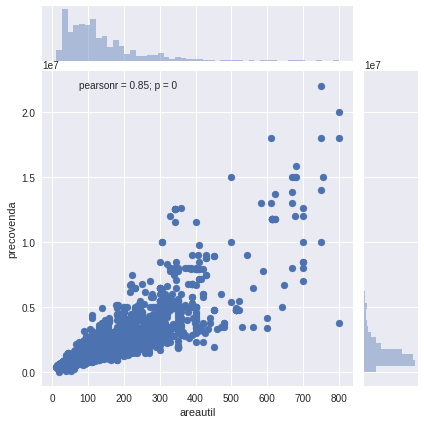

In [5]:
sns.jointplot(x='areautil',y='precovenda',data=df_copa)

- Vemos que a relação entre 'area x preço' é direta (quanto maior a área, normalmente maior o preço). Contudo ela não parece uma relação linear. Será que se ao invés de analisarmos todos os imóveis, olhassemos apenas para uma determinada rua, a relação seria mais linear? 

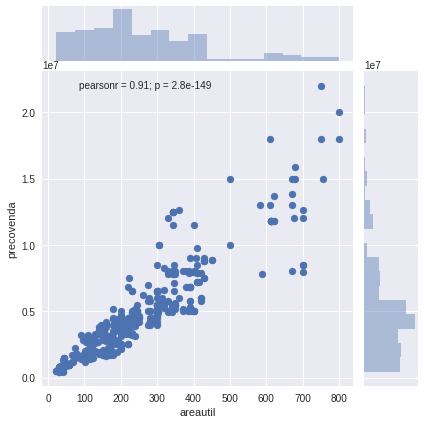

In [6]:
sns.jointplot(x='areautil',y='precovenda',data=df_copa[df_copa['endereco_logradouro'] == 'AVENIDA ATLANTICA'])

- Agora sim se parece mais com uma relação linear. Escolhemos a rua Avenida Atlantica para fazer a análise porque é na orla da praia e possivelmente a rua/avenida mais valorizada da região. O preço por m² variam consideravelmente dentro de um mesmo bairro, por isso que escolhendo apenas uma rua, a relação pareceu mais bem definida.
- Existem ainda vários fatores que podem afetar o preço do imóvel que vão além de sua área. Por isso, vemos que a relação não é perfeitamente linear.

### Verificando a correlação do preço com restaurantes/escolas/assaltos

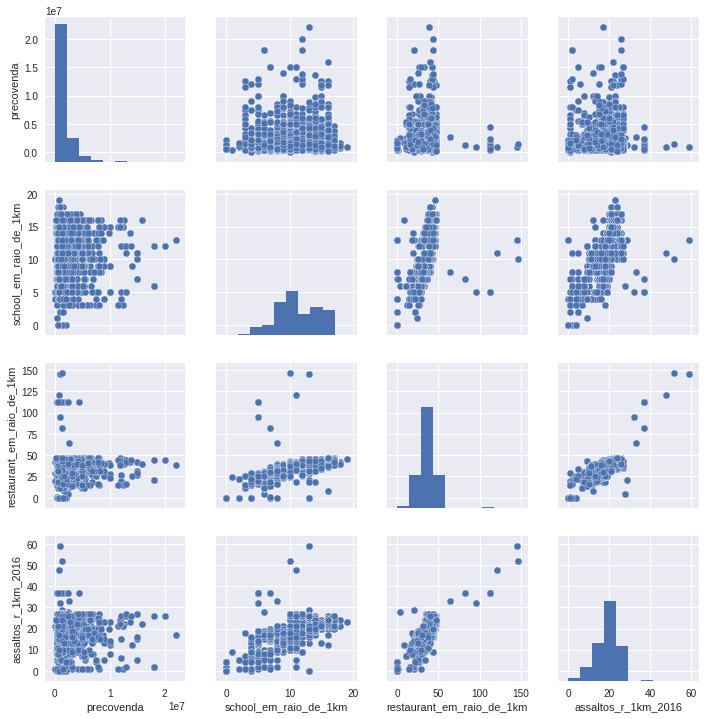

In [7]:
sns.pairplot(df_copa[['precovenda', 'school_em_raio_de_1km','restaurant_em_raio_de_1km', 'assaltos_r_1km_2016']])

- Vemos que esses atributos sozinhos não conseguem dizer muito com relação ao preço dos imóveis.

## 03 - Prevendo preço e classificando imóveis
Aqui vamos usar alguns algoritmos de Machine Learning para tentar prever o preço de imóveis em Copa. Com isso, tentaremos prever o preço de nossos proprios imóveis e identificar aqueles que estão acima e abaixo do preço.

### Regressão Linear
Aqui utilizaremos um simples algoritmo de regressão linear para tentar prever o preço dos imóveis. Vamos dividir nossa análise pelas ruas, para melhorar os resultados. No caso, algumas ruas apresentam um número muito pequeno de apartamentos, o que poderia comprometer o aprendizado do algoritmo. Por isso, essas ruas com menos de 10 imóveis serão calculados juntas.
Também iremos separar o dataset em Treino (70%) e Teste (30%), para podermos ter uma métrica de erro.

In [8]:
#Importando bibliotecas necessárias
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

#Separando as ruas que tem 10 imóveis ou mais das que tem menos que 10.
ruas_mais_de_10 = set()
ruas_menos_de_10 = set()
for i in set(df_copa['endereco_logradouro'].values):
    if len(df_copa[df_copa['endereco_logradouro'] == i]) <10:
        ruas_menos_de_10.add(i)
    else:
        ruas_mais_de_10.add(i)
        
#Armazerar datasets de treino e teste, para cada rua
X_train =  []
X_test = []
y_train = []
y_test = []

#Armazerar todos os dados, para cada rua
Data_final = []

#Armazerar os modelos treinados para cada rua
modelos = []
#Para ruas com mais de 10
for i in ruas_mais_de_10:
    X = df_copa[df_copa['endereco_logradouro'] == i].drop(['coordenadas_longitude', 'coordenadas_latitude', 'endereco_logradouro', 'endereco_bairro', 'precovenda'], axis=1)
    Y = df_copa[df_copa['endereco_logradouro'] == i]['precovenda']
    Data_final.append(df_copa[df_copa['endereco_logradouro'] == i])
    
    X_train_aux, X_test_aux, y_train_aux, y_test_aux = train_test_split(X, Y, test_size=0.3, random_state = 42)
    aux = LinearRegression()
    aux.fit(X_train_aux, y_train_aux)
    modelos.append(aux)
    X_test.append(X_test_aux)
    y_test.append(y_test_aux)

#Para ruas com menos de 10
X = df_copa[df_copa['endereco_logradouro'].isin(ruas_menos_de_10)].drop(['coordenadas_longitude', 'coordenadas_latitude', 'endereco_logradouro', 'endereco_bairro', 'precovenda'], axis=1)
Y = df_copa[df_copa['endereco_logradouro'].isin(ruas_menos_de_10)]['precovenda']
Data_final.append(df_copa[df_copa['endereco_logradouro'].isin(ruas_menos_de_10)])

X_train_aux, X_test_aux, y_train_aux, y_test_aux = train_test_split(X, Y, test_size=0.3, random_state = 42)
aux = LinearRegression()
aux.fit(X_train_aux, y_train_aux)
modelos.append(aux)
X_test.append(X_test_aux)
y_test.append(y_test_aux)

Agora usaremos os dados de treino e teste, para criar uma métrica de erro

In [9]:
#Calculando os valores dos dados de teste
pred_test = []
for i in range(len(modelos)):
    pred_test.append(modelos[i].predict(X_test[i]))
    
#Calculando o erro de cada modelo
from sklearn import metrics
error = []
for i in range(len(pred_test)):
    error.append(metrics.mean_absolute_error(y_test[i], pred_test[i]))
np.mean(error)

268946.12221409369

- Acima temos os valores dos erros de cada modelo criado (média de R$268.946). A próxima missão é prever o preço de todos os apartamentos do dataset e usar o erro para classificar apartamentos acima e abaixo do preço.

In [10]:
#Prevendo o preço de todos os imóveis e adicionando ao dataset
pred_final = []
for i in range(len(modelos)):
    pred_final.append(modelos[i].predict(Data_final[i].drop(['coordenadas_longitude', 'coordenadas_latitude', 'endereco_logradouro', 'endereco_bairro', 'precovenda'], axis=1)))
    Data_final[i]['predict'] = pred_final[i]

#Adicionando o valor do erro ao dataset
for i in range(len(error)):
    Data_final[i]['error'] = error[i]

/home/lucas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/lucas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
"""
Classificando os imóveis em acima/abaixo do preço, e colocando eles em um novo dataframe.
Essa classificação é feita a partir da margem de erro.
Apartamentos que não estão acima ou abaixo do preço não serão adicionados no novo dataframe
"""
acima = 0
abaixo = 0
lista = []
for i in range(len(Data_final)):
    for j in range(len(Data_final[i])):
        linha = Data_final[i].iloc[j][['coordenadas_longitude', 'coordenadas_latitude', 'precovenda', 'predict', 'error']].copy()
        if(linha['precovenda']+linha['error'] < linha['predict']):
            linha['class'] = 'abaixo'
            linha['id'] = linha.name
            lista.append(linha.values)
        elif(linha['precovenda']-linha['error'] > linha['predict']):
            linha['class'] = 'acima'
            linha['id'] = linha.name
            lista.append(linha.values)
df_final = pd.DataFrame(lista, columns=['coordenadas_longitude', 'coordenadas_latitude', 'precovenda', 'predict', 'error', 'class', 'zapid'])
df_final.head()

,coordenadas_longitude,coordenadas_latitude,precovenda,predict,error,class,zapid
0,-43.178520,-22.966632,2800000,2.317662e+06,404511.940332,acima,im08783797
1,-43.179221,-22.965853,550000,1.161405e+06,404511.940332,abaixo,im09571132
2,-43.179144,-22.965702,550000,1.115635e+06,404511.940332,abaixo,im17656940
3,-43.179472,-22.965311,4000000,2.896400e+06,404511.940332,acima,im06441710
4,-43.178172,-22.967273,1250000,1.868235e+06,404511.940332,abaixo,im09982489


- Agora temos um dataset chamado 'df_final', com o lat/long, preço real, preço previsto, erro, classe (acima/abaixo) e o seu id. Criei um Json com esses resultados e implementei uma webpage basica usando o leaflet para plotar os apartamentos no mapa e melhorar a visualização.

In [12]:
from IPython.display import IFrame
IFrame('copa_visu.html', width=900, height=400)

Obs: caso os pontos não estejam aparecendo, tente acessar essa página pelo Mozilla Firefox. 

## 04 -  Conclusão

Utilizando Regressão Linear, conseguimos prever o preço dos imóveis com base em seus atributos e comparar com seus preços reais, classificando aqueles acima/abaixo do preço. Por meio de uma webpage, conseguimos visualizar de forma bem intuitiva os resultados, podendo ver claramente onde estão localizados esses imóveis. Agora restam algumas questões. Será a regressão linear o melhor algoritmo para fazer essas previsões (com certeza não)? Podemos tratar ainda melhor os dados para minimizar ainda mais o erro (provavelmente sim)?
Veremos nos próximos capítulos.